In [1]:
from sklearn.decomposition import PCA
import numpy as np
from scipy import linalg
from scipy.special import gammaln
from scipy.sparse import issparse
from sklearn.utils import check_array,check_random_state, as_float_array

In [2]:
# This class is a drop-in replacement for sklearn.decomposition.PCA
class myPCA(PCA):
    def __init__(self, n_components=None, copy=True, whiten=False,
                 svd_solver='sgd', tol=1e-16, iterated_power='auto',random_state=None, 
                 beta=None, batch_size=None, max_iters=None, epoch_length=None):
        self.n_components = n_components
        self.copy = copy
        self.whiten = whiten
        self.svd_solver = svd_solver
        self.tol = tol
        self.iterated_power = iterated_power
        self.random_state = random_state
        
        self.beta = beta
        self.batch_size = batch_size
        self.max_iters = max_iters
        self.epoch_length = epoch_length
        
    def _fit(self, X):
        """Dispatch to the right submethod depending on the chosen solver."""

        # Raise an error for sparse input.
        # This is more informative than the generic one raised by check_array.
        if issparse(X):
            raise TypeError('PCA does not support sparse input. See '
                            'TruncatedSVD for a possible alternative.')

        X = check_array(X, dtype=[np.float64], ensure_2d=True,
                                    copy=self.copy)

        # Default to all components
        if self.n_components is None:
            n_components = X.shape[1]
        else:
            n_components = self.n_components

        # Handle svd_solver
        svd_solver = self.svd_solver
        if svd_solver == 'auto':
            # Small problem, just call full PCA
            if max(X.shape) <= 500:
                svd_solver = 'full'
            elif n_components >= 1 and n_components < .8 * min(X.shape):
                svd_solver = 'randomized'
            # This is also the case of n_components in (0,1)
            else:
                svd_solver = 'full'

        # Call different fits for either full or truncated SVD
        if svd_solver == 'full':
            return self._fit_full(X, n_components)
        elif svd_solver in ['arpack', 'randomized']:
            return self._fit_truncated(X, n_components, svd_solver)
        elif svd_solver == 'sgd':
            if self.beta == None:
                # set the default momentum parameter as the average of eigenvalues.
                self.beta = np.mean(X ** 2) / X.shape[1]
            if self.batch_size == None:
                self.batch_size = X.shape[0]
            if self.max_iters == None:
                self.max_iters = X.shape[1] * 1000;
            return self._fit_sgd(X, n_components, self.beta, self.batch_size, self.max_iters, self.tol)
        elif svd_solver == 'svrg':
            if self.beta == None:
                self.beta = np.mean(X ** 2) / X.shape[1]
            if self.batch_size == None:
                self.batch_size = X.shape[0]
            if self.max_iters == None:
                self.max_iters = X.shape[1] * 10
            if self.epoch_length == None:
                self.epoch_length = X.shape[0]
            return self._fit_svrg(X, n_components, self.beta, self.batch_size, self.max_iters, self.epoch_length, self.tol)

    def _fit_sgd(self, X, n_components, beta, batch_size, max_iters, tol=1e-16):
        n_samples, n_features = X.shape
        if not 1 <= n_components <= n_features:
            raise ValueError("n_components=%r must be between 1 and "
                             "n_features=%r"
                             % (n_components, n_features))

        random_state = check_random_state(self.random_state)

        # Center data
        self.mean_ = np.mean(X, axis=0)
        X -= self.mean_

        Q = np.random.randn(n_features, n_components)
        Q, _ = np.linalg.qr(Q)
        Q0 = 0
        for i in range(max_iters):
            batch_id = np.random.choice(n_samples, batch_size)
            batch = X[batch_id, :]
            Q, Q0 = 1.0 / batch_size * batch.T.dot(batch.dot(Q)) - beta * Q0, Q
            Q, R = linalg.qr(Q, mode='economic')
            Q0 = linalg.solve(R.T, Q0.T).T
            if np.mean((Q - Q0) ** 2) < tol:
                break
        A = X.T.dot(X)
        S = np.array([np.sqrt(Q[:, i].T.dot(A).dot(Q[:, i])) for i in range(n_components)])
        V = Q.T
        U = X.dot(Q).dot(np.diag(1.0 / S))
        self.n_components_ = n_components
        self.explained_variance_ = (S ** 2) / n_samples
        total_var = np.var(X, axis=0)
        self.explained_variance_ratio_ = \
            self.explained_variance_ / total_var.sum()
        if self.n_components_ < n_features:
            self.noise_variance_ = (total_var.sum() -
                                    self.explained_variance_.sum())
        else:
            self.noise_variance_ = 0.

        return U, S, V

    def _fit_svrg(self, X, n_components, beta, batch_size, max_iters, epoch_length, tol=1e-16):
        n_samples, n_features = X.shape
        if not 1 <= n_components <= n_features:
            raise ValueError("n_components=%r must be between 1 and "
                             "n_features=%r"
                             % (n_components, n_features))

        random_state = check_random_state(self.random_state)

        # Center data
        self.mean_ = np.mean(X, axis=0)
        X -= self.mean_
        A = X.T.dot(X) / n_samples

        Q = np.random.randn(n_features, n_components)
        Q, _ = linalg.qr(Q)
        Q0 = 0
        Qtilde = Q
        for epoch in range(max_iters):
            GQ = A.dot(Qtilde)
            for i in range(epoch_length):
                batch_id = np.random.choice(n_samples, batch_size)
                batch = X[batch_id, :]
                ang = Qtilde.T.dot(Q)
                Q, Q0 = 1.0 / batch_size * batch.T.dot(batch.dot(Q)) - 1 / batch_size * batch.T.dot(
                    batch.dot(Qtilde)).dot(ang) + GQ.dot(ang) - beta * Q0, Q
                Q, R = linalg.qr(Q, mode='economic')
                Q0 = linalg.solve(R.T, Q0.T).T
            Qtilde = Q
            if np.mean((Q - Q0) ** 2) < tol:
                break

        A = A * n_samples  # default setting: no normalization
        S = np.array([np.sqrt(Q[:, i].T.dot(A).dot(Q[:, i])) for i in range(n_components)])
        V = Q.T
        U = X.dot(Q).dot(np.diag(1.0 / S))
        self.n_components_ = n_components
        self.explained_variance_ = (S ** 2) / n_samples
        total_var = np.var(X, axis=0)
        self.explained_variance_ratio_ = \
            self.explained_variance_ / total_var.sum()
        if self.n_components_ < n_features:
            self.noise_variance_ = (total_var.sum() -
                                    self.explained_variance_.sum())
        else:
            self.noise_variance_ = 0.

        return U, S, V

In [3]:
# Toy example
X = np.array([[-1.0, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])

# Default PCA
pca = PCA(n_components=2)
pca.fit(X)
print("Default PCA")
print(pca.explained_variance_ratio_) 
print(pca._fit(X))

# SGD solver
sgd_pca = myPCA(n_components=2,svd_solver='sgd')
sgd_pca.fit(X)
print("\nSGD")
print(sgd_pca.explained_variance_ratio_) 
print(sgd_pca._fit(X))

# SVRG solver
svrg_pca = myPCA(n_components=2,svd_solver='svrg')
svrg_pca.fit(X)
print("\nSVRG")
print(svrg_pca.explained_variance_ratio_) 
print(svrg_pca._fit(X))

Default PCA
[ 0.99244289  0.00755711]
(array([[ 0.21956688,  0.53396977],
       [ 0.35264795, -0.45713538],
       [ 0.57221483,  0.07683439],
       [-0.21956688, -0.53396977],
       [-0.35264795,  0.45713538],
       [-0.57221483, -0.07683439]]), array([ 6.30061232,  0.54980396]), array([[-0.83849224, -0.54491354],
       [ 0.54491354, -0.83849224]]))

SGD
[ 0.99199435  0.00800565]
(array([[ 0.21842574, -0.57342864],
       [ 0.35362365,  0.34489244],
       [ 0.57204939, -0.2285362 ],
       [-0.21842574,  0.57342864],
       [-0.35362365, -0.34489244],
       [-0.57204939,  0.2285362 ]]), array([ 6.2987397 ,  0.57085745]), array([[-0.85157645, -0.52423044],
       [-0.52423044,  0.85157645]]))

SVRG
[ 0.99226714  0.00773286]
(array([[ 0.2199487 , -0.51109883],
       [ 0.35232093,  0.48810799],
       [ 0.57226963, -0.02299084],
       [-0.2199487 ,  0.51109883],
       [-0.35232093, -0.48810799],
       [-0.57226963,  0.02299084]]), array([ 6.30040234,  0.55220499]), array([[-0.

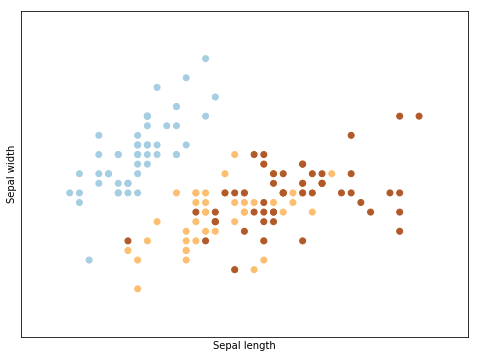

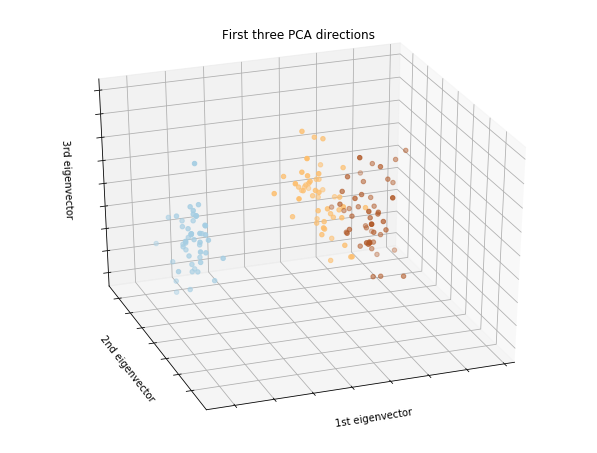

In [4]:
# real dataset example from scikit-learn
# http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
Y = iris.target

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = myPCA(n_components=3).fit_transform(iris.data)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Paired)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([]);